# 什么是超参数优化？
:label:`sec_what_is_hpo`

正如我们在前面章节中所看到的，深度神经网络带有大量在训练过程中学习到的参数或权重。除此之外，每个神经网络都有需要用户配置的额外*超参数*。例如，为了确保随机梯度下降收敛到训练损失的局部最优（见 :numref:`chap_optimization`），我们必须调整学习率和批量大小。为了避免在训练数据集上过拟合，我们可能需要设置正则化参数，如权重衰减（见 :numref:`sec_weight_decay`）或dropout（见 :numref:`sec_dropout`）。我们可以通过设置层数和每层的单元数或滤波器数量（即有效权重的数量）来定义模型的容量和归纳偏置。

不幸的是，我们不能简单地通过最小化训练损失来调整这些超参数，因为这会导致对训练数据的过拟合。例如，将正则化参数如dropout或权重衰减设为零会导致较小的训练损失，但可能会损害泛化性能。

![机器学习中的典型工作流程包括多次使用不同的超参数训练模型。](../img/ml_workflow.svg)
:label:`ml_workflow`

如果没有不同形式的自动化，超参数必须以试错的方式手动设置，这是机器学习工作流程中耗时且困难的一部分。例如，考虑在CIFAR-10上训练ResNet（见 :numref:`sec_resnet`），这在一个Amazon Elastic Cloud Compute (EC2) `g4dn.xlarge`实例上需要超过2小时。即使只是顺序尝试十个超参数配置，这也已经需要大约一天的时间。更糟糕的是，超参数通常不能直接跨架构和数据集转移 :cite:`feurer-arxiv22,wistuba-ml18,bardenet-icml13a`，并且需要为每个新任务重新优化。此外，对于大多数超参数来说，没有经验法则，需要专业知识才能找到合理的值。

*超参数优化（HPO）*算法旨在以一种有原则和自动化的方式来解决这个问题 :cite:`feurer-automlbook18a`，将其视为一个全局优化问题。默认目标是保留验证数据集上的错误，但原则上可以是任何其他业务指标。它可以与其他次要目标结合或受其限制，如训练时间、推理时间或模型复杂性。

最近，超参数优化已扩展到*神经架构搜索（NAS）* :cite:`elsken-arxiv18a,wistuba-arxiv19`，其中的目标是找到全新的神经网络架构。与经典的HPO相比，NAS在计算方面更为昂贵，并且需要额外的努力才能在实践中保持可行性。HPO和NAS都可以被认为是AutoML的子领域 :cite:`hutter-book19a`，其目标是自动化整个ML管道。

在本节中，我们将介绍HPO，并展示如何自动找到:numref:`sec_softmax_concise`中引入的逻辑回归示例的最佳超参数。

## 优化问题
:label:`sec_definition_hpo`

我们将从一个简单的玩具问题开始：搜索多类逻辑回归模型`SoftmaxRegression`的学习率，以最小化Fashion MNIST数据集上的验证误差。虽然像批量大小或训练周期数这样的其他超参数也值得调整，但我们仅为了简单起见而专注于学习率。

In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from d2l import torch as d2l

在我们运行HPO之前，首先需要定义两个要素：目标函数和配置空间。

### 目标函数

学习算法的性能可以看作是从超参数空间$\mathbf{x} \in \mathcal{X}$映射到验证损失的函数$f: \mathcal{X} \rightarrow \mathbb{R}$。对于每一次$f(\mathbf{x})$的评估，我们都必须训练并验证我们的机器学习模型，这在使用大型数据集训练深度神经网络时可能是时间和计算密集型的。给定我们的标准$f(\mathbf{x})$，我们的目标是找到$\mathbf{x}_{\star} \in \mathrm{argmin}_{\mathbf{x} \in \mathcal{X}} f(\mathbf{x})$。

没有简单的方法来计算$f$相对于$\mathbf{x}$的梯度，因为这需要在整个训练过程中传播梯度。尽管最近有一些工作 :cite:`maclaurin-icml15,franceschi-icml17a` 通过近似的“超梯度”来驱动HPO，但现有的方法还没有一个能够与最先进水平竞争，因此我们不会在这里讨论它们。此外，评估$f$的计算负担要求HPO算法尽可能用最少的样本接近全局最优解。

神经网络的训练是随机的（例如，权重随机初始化，小批量随机采样），因此我们的观察值将是嘈杂的：$y \sim f(\mathbf{x}) + \epsilon$，其中通常假设$\epsilon \sim N(0, \sigma)$观测噪声为高斯分布。

面对所有这些挑战，我们通常试图快速识别出一组表现良好的超参数配置，而不是精确达到全局最优解。然而，由于大多数神经网络模型的巨大计算需求，即使这样也可能需要几天或几周的时间。我们将在:numref:`sec_mf_hpo`中探讨如何通过分发搜索或使用更廉价的目标函数近似来加速优化过程。

我们从一种计算模型验证误差的方法开始。

In [2]:
class HPOTrainer(d2l.Trainer):  #@save
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 -  accuracy / val_batch_idx

我们针对超参数配置`config`（包括`learning_rate`）来优化验证误差。在每次评估中，我们会训练模型`max_epochs`个周期，然后计算并返回其验证误差：

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

### 配置空间
:label:`sec_intro_config_spaces`

除了目标函数 $f(\mathbf{x})$，我们还需要定义可行集 $\mathbf{x} \in \mathcal{X}$ 以进行优化，这被称为*配置空间*或*搜索空间*。对于我们的逻辑回归示例，我们将使用：

In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

在这里，我们使用了SciPy中的`loguniform`对象，该对象表示对数空间中-4到-1之间的均匀分布。这个对象允许我们从这种分布中抽取随机变量。

每个超参数都有一个数据类型，例如`learning_rate`的`float`类型，以及一个闭合有界范围（即下限和上限）。我们通常为每个超参数分配一个先验分布（如均匀或对数均匀）以从中采样。一些正值参数，如`learning_rate`，在对数尺度上表示最佳，因为最优值可以相差几个数量级，而其他参数，如动量，则采用线性尺度。

下面是一个包含多层感知机典型超参数及其类型和标准范围的配置空间的简单示例。

: 多层感知机的示例配置空间
:label:`tab_example_configspace`

| 名称                | 类型        | 超参数范围           | 对数尺度 |
| :----:              | :----:      |:------------------------------:|:---------:|
| learning rate       | float       |      $[10^{-6},10^{-1}]$       |    是    |
| batch size          | integer     |           $[8,256]$            |    是    |
| momentum            | float       |           $[0,0.99]$           |    否    |
| activation function | categorical | $\{\textrm{tanh}, \textrm{relu}\}$ |     -     |
| number of units     | integer     |          $[32, 1024]$          |    是    |
| number of layers    | integer     |            $[1, 6]$            |    否     |



一般来说，配置空间$\mathcal{X}$的结构可能很复杂，并且与$\mathbb{R}^d$大不相同。实际上，某些超参数可能依赖于其他超参数的值。例如，假设我们要调整一个多层感知机的层数，以及每一层的单元数。第$l\textrm{-th}$层的单元数只有在网络至少有$l+1$层时才有意义。这些高级HPO问题超出了本章的讨论范围。有兴趣的读者可参考:cite:`hutter-lion11a,jenatton-icml17a,baptista-icml18a`。

配置空间对于超参数优化起着重要作用，因为没有任何算法能够找到不在配置空间内的东西。另一方面，如果范围太大，找到表现良好的配置所需的计算预算可能会变得不可行。

## 随机搜索
:label:`sec_rs`

*随机搜索*是我们将考虑的第一个超参数优化算法。随机搜索的主要思想是独立地从配置空间中抽样，直到预定义的预算（例如最大迭代次数）耗尽，并返回观察到的最佳配置。所有评估都可以并行独立执行（见:numref:`sec_rs_async`），但为了简化，这里我们使用顺序循环。

    validation_error = 0.17070001363754272


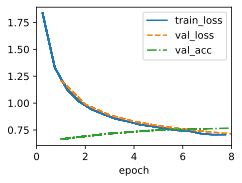

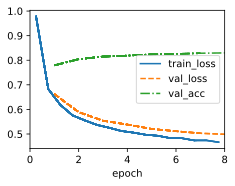

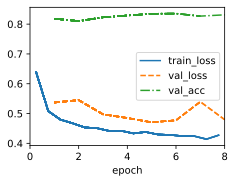

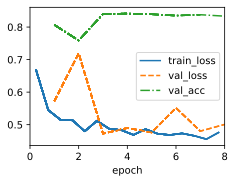

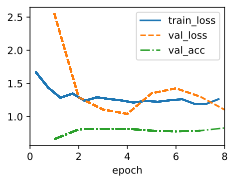

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

最佳的学习率就是验证误差最低的那个。

In [6]:
best_idx = np.argmin(errors)
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.09844872561810249


由于其简单性和通用性，随机搜索是最常用的HPO算法之一。它不需要任何复杂的实现，并且只要我们能够为每个超参数定义某种概率分布，就可以应用于任何配置空间。

不幸的是，随机搜索也存在一些缺点。首先，它不会根据迄今为止收集的先前观察结果调整采样分布。因此，采样一个表现较差的配置与采样一个表现较好的配置的可能性相同。其次，所有配置花费相同的资源，即使某些配置可能显示出较差的初始性能，并且不太可能超过之前看到的配置。

在接下来的部分中，我们将研究更高效的超参数优化算法，这些算法通过使用模型来指导搜索，从而克服了随机搜索的缺点。我们还将研究能够自动停止表现不佳的配置评估过程以加速优化过程的算法。

## 摘要

在本节中，我们介绍了超参数优化（HPO）以及如何通过定义配置空间和目标函数将其表述为全局优化问题。我们还实现了第一个HPO算法——随机搜索，并将其应用于一个简单的softmax分类问题上。

虽然随机搜索非常简单，但它是网格搜索更好的替代方案，后者只是评估一组固定的超参数。随机搜索在某种程度上缓解了维度灾难 :cite:`bellman-science66`，如果标准主要依赖于一小部分超参数，则随机搜索可以比网格搜索效率高得多。

## 练习

1. 在本章中，我们在一个不相交的训练集上训练模型后优化模型的验证错误。为了简化，我们的代码使用了`Trainer.val_dataloader`，它映射到围绕`FashionMNIST.val`的加载器。
    1. 通过查看代码说服自己这意味着我们使用原始的FashionMNIST训练集（60000个样本）进行训练，并使用原始*测试集*（10000个样本）进行验证。
    2. 这种做法为什么可能会有问题？提示：重新阅读:numref:`sec_generalization_basics`，特别是关于*模型选择*的部分。
    3. 我们应该怎么做？
2. 我们上面提到通过梯度下降进行超参数优化是非常困难的。考虑一个小问题，例如在FashionMNIST数据集（:numref:`sec_mlp-implementation`）上用批量大小为256的方式训练两层感知机。我们希望调优SGD的学习率以最小化一个训练周期后的验证指标。
    1. 为什么我们不能为此目的使用验证*误差*？你会在验证集上使用什么指标？
    2. 大致勾画出经过一个训练周期后的验证指标的计算图。你可以假设初始权重和超参数（如学习率）是该图的输入节点。提示：重读关于计算图的内容:numref:`sec_backprop`。
    3. 粗略估计在此图的前向传递过程中你需要存储的浮点数值数量。提示：FashionMNIST有60000个案例。假设所需的内存主要由每层之后的激活值主导，并查阅:numref:`sec_mlp-implementation`中的层宽度。
    5. 除了大量的计算和存储需求之外，基于梯度的超参数优化还会遇到哪些其他问题？提示：重新阅读关于消失和爆炸梯度的内容:numref:`sec_numerical_stability`。
    6. *进阶*：阅读:cite:`maclaurin-icml15`以了解一种优雅（但仍有些不实用）的基于梯度的HPO方法。
3. 网格搜索是另一种HPO基准，在这种搜索中，我们为每个超参数定义等间距网格，然后迭代组合的笛卡尔积以建议配置。
    1. 我们上面提到，如果标准主要依赖于一小部分超参数，那么对于相当数量的超参数来说，随机搜索可以比网格搜索效率高得多。为什么会这样？提示：阅读:cite:`bergstra2011algorithms`。

[讨论](https://discuss.d2l.ai/t/12090)